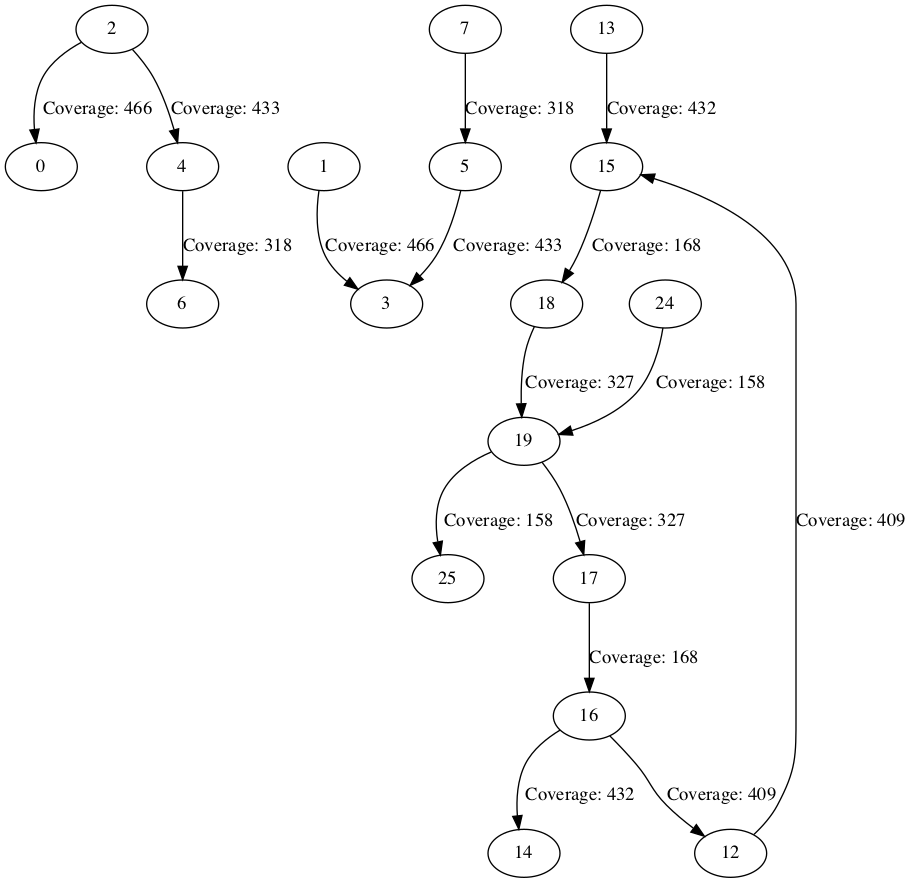

In [105]:
import pysam
from collections import defaultdict
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import pygraphviz as pvg


class Vertex:
    def __init__(self, name):
        self.name = name
        self.input_edges = []
        self.output_edges = []
        self.input_degree = 0
        self.output_degree = 0

class Edge:

    def __init__(self, length, coverage=0):
        self.coverage = coverage
        self.length = length

class DeBruijnGraph:

    def __init__(self, sequence, k):
        self.k = k
        self.sequence = sequence
        self.format = sequence[-sequence[::-1].find('.'):]
        self.vertices = {}
        self.edges = defaultdict(lambda: Edge(self.k + 1))
        self.visited = False

    def get_complementary_sequence(self, seq):
        complementary_dict = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
        reverse_complementary = ''.join([complementary_dict[ch] for ch in seq][::-1])
        return reverse_complementary

    def add_vertex(self, seq):
        self.vertices[seq] = Vertex(seq)

    def add_edge(self, seq):
        self.edges[seq].coverage += 1
        if self.edges[seq].coverage == 1:
            self.vertices[seq[:-1]].output_degree += 1
            self.vertices[seq[:-1]].output_edges.append(seq)
            self.vertices[seq[1:]].input_degree += 1
            self.vertices[seq[1:]].input_edges.append(seq)

    def add_vertices_fasta(self):
        with pysam.FastaFile(self.sequence) as file:
            for read_id in file.references:
                sequence = file.fetch(read_id)

                for i in range(len(sequence) - self.k + 1):
                    kmer = sequence[i:i + self.k]
                    reverse_kmer = self.get_complementary_sequence(kmer)
                    if not (kmer in self.vertices):
                        self.add_vertex(kmer)
                        self.add_vertex(reverse_kmer)

    def add_edges_fasta(self):
        with pysam.FastaFile(self.sequence) as file:
            for read_id in file.references:
                sequence = file.fetch(read_id)

                for i in range(len(sequence) - self.k):
                    kmer = sequence[i:i + self.k + 1]
                    reverse_kmer = self.get_complementary_sequence(kmer)
                    self.add_edge(kmer)
                    self.add_edge(reverse_kmer)
                    
    def add_vertices_fastq(self):
        with pysam.FastqFile(self.sequence) as file:
            for read in file:
                sequence = read.sequence

                for i in range(len(sequence) - self.k + 1):
                    kmer = sequence[i:i + self.k]
                    rev_kmer = self.get_complementary_sequence(kmer)
                    if not (kmer in self.vertices):
                        self.add_vertex(kmer)
                        self.add_vertex(rev_kmer)

    def add_edges_fastq(self):
        with pysam.FastqFile(self.sequence) as file:
            for read in file:
                sequence = read.sequence

                for i in range(len(sequence) - self.k):
                    kmer = sequence[i:i + self.k + 1]
                    rev_kmer = self.get_complementary_sequence(kmer)
                    self.add_edge(kmer)
                    self.add_edge(rev_kmer)



    def construction(self):
        self.add_vertices_fasta()
        self.add_edges_fasta()

    def merge_edges(self, node):

        o_edge_id = node.output_edges[0]
        i_edge_id = node.input_edges[0]
        o_edge = self.edges[o_edge_id]
        i_edge = self.edges[i_edge_id]

        n_edge = i_edge_id + o_edge_id[self.k:]
        n_cov = o_edge.coverage + i_edge.coverage
        n_len = i_edge.length + o_edge.length - self.k

        self.vertices[o_edge_id[-self.k:]].input_edges.remove(o_edge_id)
        self.vertices[o_edge_id[-self.k:]].input_edges.append(n_edge)
        self.vertices[i_edge_id[:self.k]].output_edges.remove(i_edge_id)
        self.vertices[i_edge_id[:self.k]].output_edges.append(n_edge)

        self.edges[n_edge] = Edge(n_len, n_cov)

        del self.vertices[node.name]
        del self.edges[o_edge_id]
        del self.edges[i_edge_id]
        
    
    def simplification(self):
        names_list = list(self.vertices.keys())
        for vertex_name in names_list:
            node = self.vertices[vertex_name]
            if (node.input_degree == 1) and (node.output_degree == 1):
                self.merge_edges(node)
        for edge in self.edges:
            self.edges[edge].coverage = round(self.edges[edge].coverage / (self.edges[edge].length - self.k))
        self.node_names = {name: i for i, name in enumerate(self.vertices.keys())}
        
        
    def simplification_tip(self):
        for name, v in list(self.edges.items()):
            if (v.length < 2*self.k):
                del self.edges[name]
        len_list = len(list(self.edges.items()))
        mean_coverage=0
        for name, v in list(self.edges.items()):
            mean_coverage += v.coverage/len_list
        for name, v in list(self.edges.items()):
            if (v.coverage < mean_coverage/2):
                del self.edges[name]
                
   
    def visit(self):
        self.graph = pvg.AGraph(strict=False, directed=True)
        added = []
        for name, v in self.edges.items():
            ls = f'\nCoverage: {v.coverage}'
            self.graph.add_edge(self.node_names[name[:self.k]],
                                self.node_names[name[-self.k:]],
                                label=ls)
            added.append(name[:self.k])
            added.append(name[-self.k])
        self.visited = True

    def write_to_fasta(self, output):
        records = (SeqRecord(Seq(k, 'DNA'), str(i)) for i, k in enumerate(self.edges))
        SeqIO.write(records, output, 'fasta')

    def get_draw_graph(self, filename):
        if not self.visited:
            self.visit()
        self.graph.draw(filename, prog='dot')

    def write_to_dot(self, output):
        if not self.visited:
            self.visit()
        self.graph.draw(output, prog='dot')

def run(input_filename, output_filename, picture):
    graph = DeBruijnGraph(input_filename, 10)
    graph.construction()
    graph.simplification()
    graph.simplification_tip()
    graph.write_to_dot(output_filename)
    graph.get_draw_graph(picture)


run('s_6.first1000.fastq', 's_6_first1000.dot', 's_6_first1000.png')
Image(filename='s_6_first1000.png')

# run('s_6.first10000.fastq', 's_6_first10000.dot', 's_6_first10000.png')
# Image(filename='s_6_first10000.png')

# run('s_6.first100000.fastq', 's_6_first100000.dot', 's_6_first100000.png')
# Image(filename='s_6_first100000.png')